# Species abundance model for the Northeast Continental Shelf region 
<img src=https://github.com/PACEHackWeek/proj_2025_sdm/raw/main/proj_pace_sdm_logo.png width="350">

### Description:
This notebook was created at the PACE Hackweek 2025. We created a tutorial for running a marine-specific species abundance model in Python. Our use-case will be with fisheries data collected on the [NOAA NEFSC bottom trawl](https://www.fisheries.noaa.gov/new-england-mid-atlantic/science-data/2025-spring-bottom-trawl-survey-completed-northeast) survey. 

### Authors (alphabetical): 
* Artem Dzhulai (URI)
* Eli Holmes (NOAA Fisheries) 
* Sajna Hussain (Oregon State)
* Jamon Jordan (Oregon State)
* Natalie McCourt (UMBC)
* Haley Synan (NOAA Fisheries/IBSS)

### History:
>* *8/4/25: notebook initialized, code added to stream pace and glorys data*
>* *8/5/25: pace match functions added, glorys matchup functions added*
>* *8/6/25: added code to fill nans with monthly data, added code from Ryan vandermeulen, model code initiated, markdown updated*


##### To get push access to SDM repo:
CD to local repo directory. Run ```gh-scoped-creds``` in the terimal and follow instructions.

## Contents 
1. [Work with fisheries Data](#1.-Work-with-fisheries-data)
2. [Load and match PACE Data](#2.-Load-and-match-PACE-data)
3. [Load and match GLORYS Data](#3.-Load-and-match-GLORYS-data)
4. [Create SDM model!](#4.-Create-SDM-model!)
5. [Visualize results](#5.-Visualize-results)

```mermaid
---
title: WORKFLOW
---
graph LR
A[Observation data] --> G{Extract data from predictors\n to match to point data}
B[Predictor data] --> G
G --> H[Run BTR model]
H --> i[Visualize results]
H --> l[Feature importance]
```

```mermaid
flowchart TD
    A["DATA SOURCES"] --> B["OBSERVATION DATA"]
    B["OBSERVATION DATA"] --> C["Fisheries data"]
    C --> G["Abundance"]
    A --> D["PREDICTOR DATA"]
    D --> E["GLORYS12V1"]
    E --> H["Bottom Temperature"]
    E --> J["Bottom Salinity"]
    D --> F["PACE L3M"]
    F --> K["AVW"]
    F --> L["Chlor_a"]
    F --> P["RRS brightness"]
    classDef GreenShape fill:#E0E0E0,stroke-width:1px,stroke:black;
    classDef gshape fill:#A2D1FC,stroke-width:1px,stroke:black;
    classDef bshape fill:#FF612B,stroke-width:1px,stroke:black;
    classDef hshape fill:#FFBBA1,stroke-width:1px,stroke:black;
    classDef ishape fill:#FFE4A1,stroke-width:1px,stroke:black;
    classDef pshape fill:#A1FFD9,stroke-width:1px,stroke:black;
    classDef oshape fill:#6FB5F2,stroke-width:1px,stroke:black;

    class C,G gshape
    class B oshape
    class D bshape
    class E,H,J hshape
    class F,K,L,P ishape

    class A GreenShape
    
```

In [4]:
!pip install copernicusmarine
!pip install xgboost
!pip install shap

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy
import numpy as np
import xarray as xr
import earthaccess
from match_func import match_nearest
import netCDF4
import h5netcdf
import math
import copernicusmarine
import geopandas as gpd
import earthaccess
import xarray as xr
import cartopy.feature as cfeature
from shapely.ops import unary_union
from tqdm import tqdm
import cmocean
from simplebbox import simple_bbox
auth = earthaccess.login(persist=True)

## 1. Work with fisheries data
About the data: We will be using data from the [NOAA's Northeast Bottom Trawl (BTS) Survey](https://www.fisheries.noaa.gov/about/northeast-ecosystems-surveys). This survey covers Maine to Cape Hatteras and is conducted yearly (for the past 60+ years!). We used data from the Spring 2024 BTS survey, which completed **367 stations** from **March 6 to May 13**. 
<br>

In order to utilize species presence in our analysis, we read in the Northeast Bottom Trawl Survey data as a pandas DataFrame. To ensure proper matching with other datasets, the "date" column was converted into a datetime object and the coordinates to floats. Below are the first five rows of the initial trawl_df, as well as the data types corresponsing to each variable (date, coordinates, mean depth, and swept area).  
<br>

Lets zoom out to see where in the world our study region is. Thank Eli H for creating this function!!!


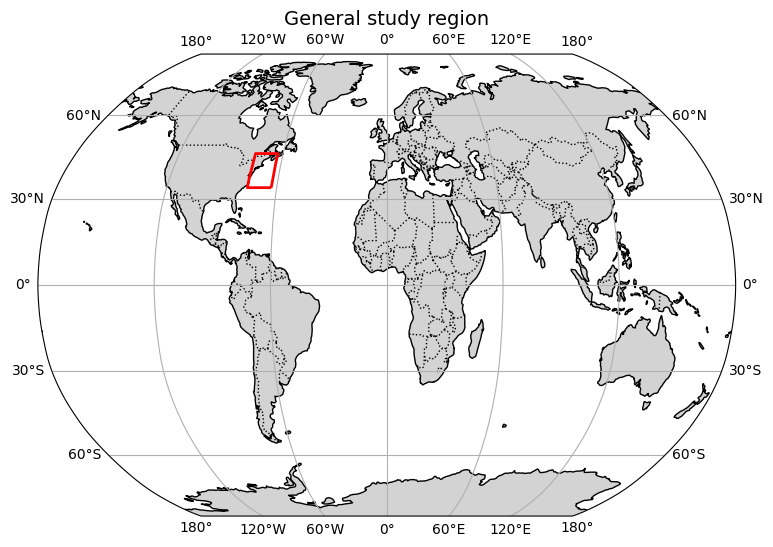

In [2]:
bbox=[-76, 34, -63, 46]
simple_bbox(bbox,'Robinson','General study region')

In [2]:
os.chdir(r'/home/jovyan/Hackweek2025/proj_2025_sdm/data')
trawl_df = pd.read_csv('fisheries_with_pace_rrs_avw2.csv') #read data 
#trawl_df = pd.read_csv('/home/jovyan/proj_2025_sdm/data/fisheries_with_pace_rrs_avw2.csv') #read data 
# --- Data Cleaning (Crucial Step!) ---

# 1. Ensure the date column is a proper datetime object.
#    This is vital for matching with the environmental data.
trawl_df['TOWDATETIME_EST'] = pd.to_datetime(trawl_df['TOWDATETIME_EST'])

# 2. Ensure coordinates are numeric
trawl_df['LON'] = pd.to_numeric(trawl_df['LON'])
trawl_df['LAT'] = pd.to_numeric(trawl_df['LAT'])

# Display the first few rows and data types to verify
print("Catch Data Head:")
print(trawl_df.head())
print("\nData Types:")
print(trawl_df.info())

# --- Standardize Column Names to Match Xarray Dims ---
# This is the crucial step to ensure congruency.
rename_dict = {
    'TOWDATETIME_EST': 'time',
    'LAT': 'latitude',
    'LON': 'longitude'
}
trawl_df = trawl_df.rename(columns=rename_dict)

Catch Data Head:
      TOWDATETIME_EST        LAT        LON  MEAN_DEPTH  SWEPT_AREA_km  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24       0.021282   
1 2024-03-07 14:32:00  38.498596 -74.477395          40       0.024311   
2 2024-03-07 17:44:00  38.411974 -74.502885          39       0.023835   
3 2024-03-07 20:29:00  38.505238 -74.832046          25       0.021510   
4 2024-03-07 22:45:00  38.556784 -74.897495          21       0.019174   

   acadian redfish  alewife  alligatorfish  american lobster  american plaice  \
0              0.0      0.0            0.0               0.0              0.0   
1              0.0      0.0            0.0               0.0              0.0   
2              0.0      0.0            0.0               0.0              0.0   
3              0.0      0.0            0.0               1.0              0.0   
4              0.0      0.0            0.0              27.0              0.0   

   ...   Rrs_707   Rrs_708   Rrs_709   Rrs_711   Rr

## Data exploration
We wanted to find a species (or few) that would be the most useful to model. First, we sorted the species by total number of observations over the entire survey. We then plotted the 6 most common species as a faux time series, using station number instead of datetime. We decided to study species that have more than 50,000 observations over the survey period. This is a crude way to remove the species that were rarely seen and wouldn't be a good fit to model. The image below presents the distribution of the 6 most populous species across the different collection stations. 

/tmp/ipykernel_1711/79794507.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['station'] = np.arange(1,len(sub)+1) #add station col


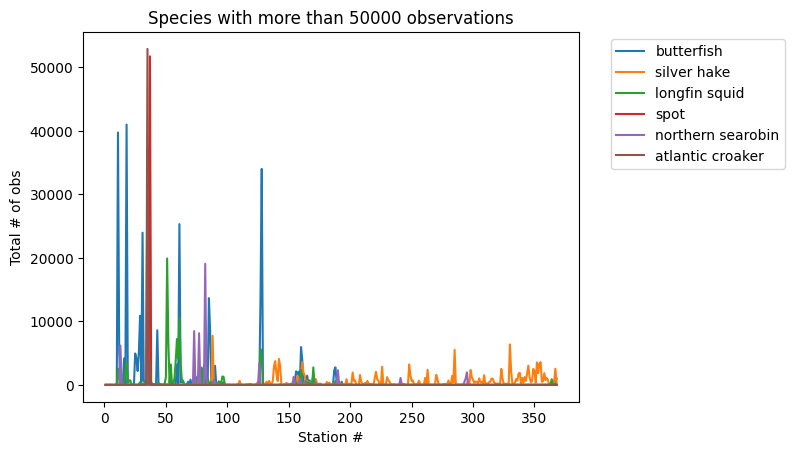

In [4]:
matched=[]
for item in trawl_df.columns:
    if 'Rrs' in item:  # Using the 'in' operator for substring check
        pass
    else: 
        matched.append(item)

sub = trawl_df[list(matched)] #subset (remove RRS columns) 
sub['station'] = np.arange(1,len(sub)+1) #add station col

tot_sum = {}
for s in sub.columns[5:-2]:
   tot_sum.update({s:int(sub[s].sum())})  #get total sum of all values 

sorted_tot_sum = sorted(tot_sum.items(), key=lambda item: item[1],reverse=True) #sort by max-->min


abu=[]
for val in sorted_tot_sum:
    if val[1]>50000: #if more than 50000 observations 
        abu.append(val[0])


#plot max valeus 
for s in sub[abu].columns:
    plt.plot(sub.station, sub[s],label=s)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', )
plt.xlabel('Station #')
plt.ylabel('Total # of obs')
plt.title('Species with more than 50000 observations')
plt.show()

Now we have the 6 most dominant (in total # of obs) over the survey period. We 

In [6]:
min_lat = trawl_df['latitude'].min()
max_lat = trawl_df['latitude'].max()
min_lon = trawl_df['longitude'].min()
max_lon = trawl_df['longitude'].max()

# Print DataFrame shape and columns (for trawl_df)
print("\n--- Trawl Data Shape and Columns ---")
print("Trawl DataFrame Shape:", trawl_df.shape)
#print("Trawl DataFrame Columns:", trawl_df.columns.tolist())


print(f"Trawl data latitude range: {min_lat} to {max_lat}")
print(f"Trawl data longitude range: {min_lon} to {max_lon}")
print("Trawl Data Time Range:", trawl_df["time"].min(), "to", trawl_df["time"].max())


--- Trawl Data Shape and Columns ---
Trawl DataFrame Shape: (368, 372)
Trawl data latitude range: 34.4105285 to 44.425485
Trawl data longitude range: -75.939414 to -65.8127125
Trawl Data Time Range: 2024-03-07 10:58:00 to 2024-05-13 07:15:00


The following images visualize the presence/absence data for the species of interest at each of the trawl stations. 

Text(0.5, 0.98, 'Species presence by station')

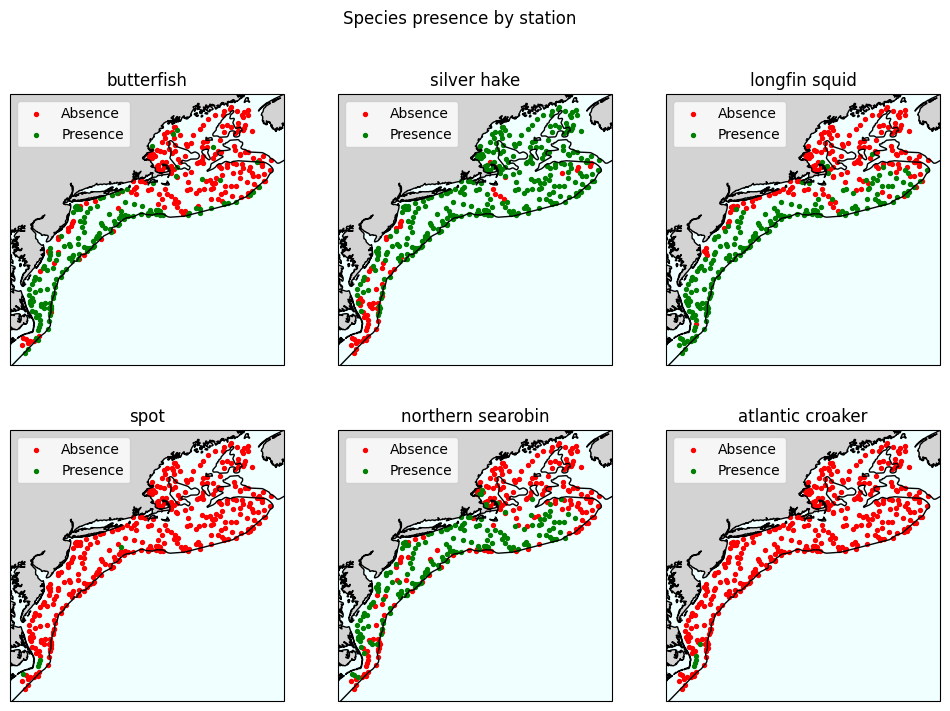

In [7]:
# Create a figure and a 3x2 grid of subplots
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 8),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

# Example data for plotting
x = np.linspace(0, 10, 100)

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    ax.scatter(sub[sub[sub[abu].columns[i]]==0].longitude, sub[sub[sub[abu].columns[i]]==0].latitude,c='r',s=8,label='Absence')
    ax.scatter(sub[sub[sub[abu].columns[i]]!=0].longitude, sub[sub[sub[abu].columns[i]]!=0].latitude,c='g',s=8,label='Presence')
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    ax.set_title(sub[abu].columns[i])
    ax.legend()
fig.suptitle('Species presence by station')

### The chosen ones!!
**LONGFIN SQUID**
<img src="https://www.joelsartore.com/wp-content/uploads/stock/INV004/INV004-00045.jpg" width="400" height="400"/>
**BUTTERFISH**
<img src="https://www.thefisherman.com/wp-content/uploads/2023/04/20230406-american_butterfish_8820.jpg" width="400" height="400"/>
<br>
**SILVER HAKE**
<img src="https://www.worldlifeexpectancy.com/images/a/w/b/merluccius-bilinearis/merluccius-bilinearis.webp" width="400" height="400"/>
**SPOT**
<img src="https://coastalreview.org/wp-content/uploads/2022/01/Leiostomus-xanthurus-Black-1024x576-1.png" width="400" height="400"/>


## 2. Load and match PACE data
For this example, we used **Chlorophyll-a**, **Apparent Visible Wavelength (AVW)**, and **RRS brightness** for March-May 2024.<br>
*Apparent visible wavelength:* is 1-D measure of the color of the water, related to the spectral shape of the light reflected from the ocean's surface <br>
*RRS brightness:* is the brainchild of **Ryan Vandermeulen.** It is the total amount of brightness from the water. It is calculated usign a numerical integration using the trapezoidal rule of the Rrs values between 400-700 nm.
<br>
<br>

To match up NOAA fisheries data and PACE OCI product, we added time dimension to PACE data.<br>
We used  the `open_mfdataset` function to combine multiple files concatenating the data by `datetime`.

In [3]:
def get_pace_path(trawl_df, short_name):
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.8*.4km*")
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 


def open_pace(paths): 
    d8=[]
    for file in paths: 
        d = xr.open_dataset(file)
        d8.append(d.attrs['time_coverage_start'])
    ds = xr.open_mfdataset(paths, combine='nested',concat_dim='datetime').assign_coords({'time':d8}) #add new dimension and assign time data to it
    ds = ds.rename({'datetime':'time'}) #rename to time
    ds = ds.where((ds.lat > 34.40918) & (ds.lat < 46.362305) & (-63>ds.lon) & (-77< ds.lon),drop=True) #general spatial subset
    ds = ds.rename({'lat':'latitude','lon':'longitude'})
    #ds['time']=[pd.to_datetime(d) for d in ds.time.values] #convert to pandas datetime 
    ds['time'] = pd.to_datetime(ds.time) #convert to pandas datetime 
    return ds

#trawl_df pre-processing
trawl_df['date'] = [str(d).split(' ')[0] for d in trawl_df.time] 
#trawl_df['time'] = [pd.to_datetime(d.replace(' ','T')) for d in trawl_df.TOWDATETIME_EST] #format as timestamp

#get pace data 
paths_avw= get_pace_path(trawl_df,"PACE_OCI_L3M_AVW")
paths_chl= get_pace_path(trawl_df,"PACE_OCI_L3M_CHL")
paths_kd= get_pace_path(trawl_df,"PACE_OCI_L3M_KD")


ds_avw, ds_chl = list(map(open_pace,[paths_avw, paths_chl])) #get path values for each variable 

#match data 
data=[ds_avw, ds_chl] #list of datasets
var_names =['avw','chlor_a'] #list of variable names 
for d in range(len(data)): 
    if d == 0: 
        trawl_df = match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time) #get full trawl_df + avw 
    else: 
        trawl_df[var_names[d]]=match_nearest(trawl_df,data[d],var_names[d],var_names[d],date=trawl_df.time)[var_names[d]] #add chl in 
    
# Check for any missing values, which could indicate a mismatch
#print("\nMissing values count:")
#print(trawl_df[['avw','chlor_a'].isnull().sum())

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9 [00:00<?, ?it/s]

<br>To add bathymetry on the map, we used `cartopy.feature` library.

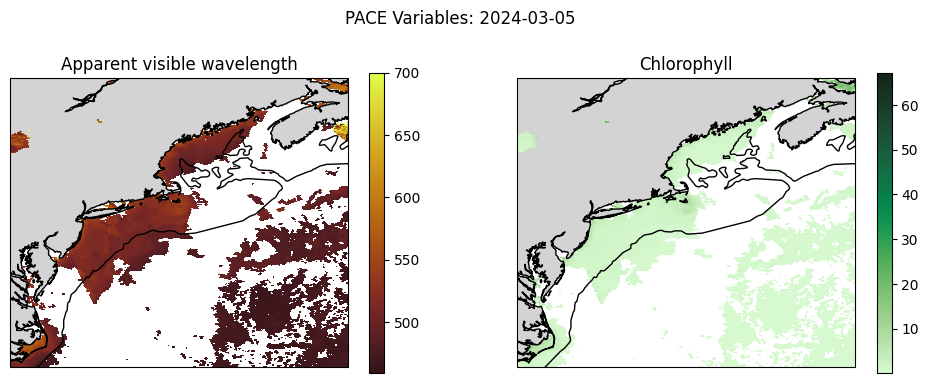

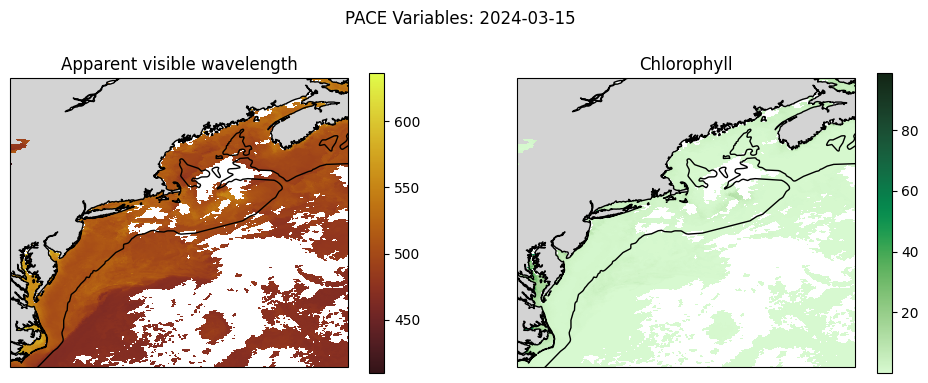

In [10]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))

for i in range(2):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

    im=axs[0].pcolormesh(ds_avw.longitude, ds_avw.latitude, ds_avw.avw[i],cmap=cmocean.cm.solar)
    axs[0].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[0].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[0].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[0].set_title('Apparent visible wavelength')
    
    im1=axs[1].pcolormesh(ds_chl.longitude, ds_chl.latitude, ds_chl.chlor_a[i],cmap=cmocean.cm.algae)
    axs[1].add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    axs[1].add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
    axs[1].add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    axs[1].set_title('Chlorophyll')
    
    fig.colorbar(im, ax=axs[0],shrink=0.65)
    fig.colorbar(im1, ax=axs[1],shrink=0.65)
    fig.suptitle('PACE Variables: '+ str(ds_avw.time[i].values).split('T')[0],y=0.85)
    fig.show()


<br>After matching 8-day PACE data, we still had some NAN values.<br>
We used **monthly** data to fill them in.

Text(0.5, 1.0, '8-Day chlor_a \n Visualize missing data after matchup')

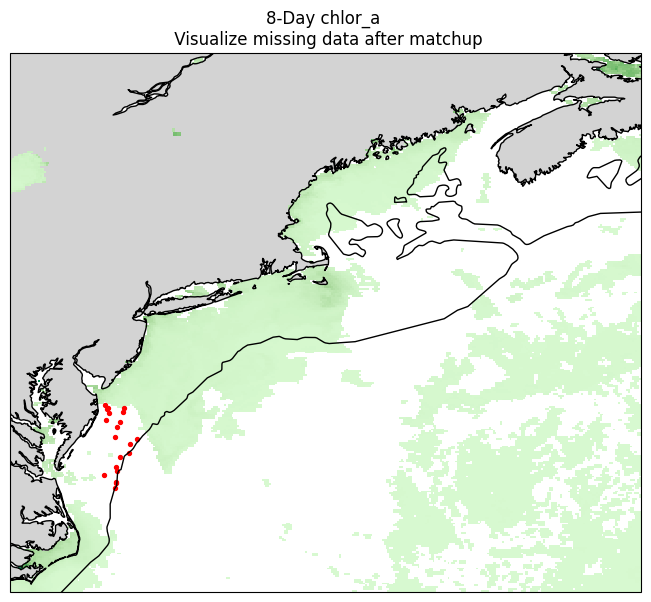

In [10]:
isna= [math.isnan(d) for d in trawl_df.avw]
fig = plt.figure(figsize=(10, 7)) #set figure size
map_projection = cartopy.crs.PlateCarree() #set map projection
ax = plt.axes(projection=map_projection) 
plt.pcolormesh(ds_chl.longitude, ds_chl.latitude, ds_chl.chlor_a[0],cmap=cmocean.cm.algae)
plt.scatter(trawl_df[isna][:20].longitude, trawl_df[isna][:20].latitude,s=8,c='r')
ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask
ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
plt.title('8-Day chlor_a \n Visualize missing data after matchup')

<br>We created `get_pace_nan_replace` function to address NaN values to allow for more robust data.<br>
Since **avw** values are objects, we created `extract_scalar` function to extracts the actual, usable scalar value (a float).

In [4]:
def get_pace_nan_replace(trawl_df, short_name):
    #used to address NaN values to allow for more robust data
    tspan = (trawl_df.date.min(), trawl_df.date.max())
    bbox = (-76.75, 33, -63, 46) #west,south,east,north
    #clouds = (0, 50)
    results = earthaccess.search_data(
        short_name=short_name,
        temporal=tspan,
        bounding_box=bbox,
        granule_name="*.M*.4km*") #update to month
        #cloud_cover=clouds,
    paths = earthaccess.open(results)
    return paths 

def extract_scalar(val): 
    #since avw values are objects, this function extracts the 
    #actual, usable scalar value (a float)
    if isinstance(val, (list, np.ndarray)): #checks if instance of a list or a NumPy list
        if np.size(val)== 1:
            return val[0] if isinstance(val, list) else val.item()
        else:
            return np.nan 
    elif hasattr(val, 'item'): #unwraps from NumPy object, xarray scalar DataArray, etc.
        try:
            return val.item()
        except:
            return np.nan
    return val

#converting datatype to usable float64
trawl_df['avw'] = trawl_df['avw'].apply(extract_scalar)
trawl_df['chlor_a'] = trawl_df['chlor_a'].apply(extract_scalar)

trawl_df['avw'] = pd.to_numeric(trawl_df['avw'], errors='coerce') #another conversion to float
trawl_df['chlor_a'] = pd.to_numeric(trawl_df['chlor_a'], errors='coerce') #another conversion to float

#creating list of indices containing NaN values
na_index_avw = trawl_df[trawl_df.avw.isna()].index 
na_index_chl = trawl_df[trawl_df.chlor_a.isna()].index

#creates dataset containing only NaN values
trawl_df_avw_nan_only = trawl_df.loc[na_index_avw] 
trawl_df_chl_nan_only = trawl_df.loc[na_index_chl] 

trawl_df_avw_nan_only = trawl_df_avw_nan_only.drop('avw', axis = 1)
trawl_df_chl_nan_only = trawl_df_chl_nan_only.drop('chlor_a', axis = 1)

nan_avw_path = get_pace_nan_replace(trawl_df,"PACE_OCI_L3M_AVW")
nan_chl_path = get_pace_nan_replace(trawl_df,"PACE_OCI_L3M_CHL")

nan_avw_ds, nan_chl_ds = list(map(open_pace,[nan_avw_path, nan_chl_path])) #get path values for each variable 

matched_monthly = match_nearest(trawl_df_avw_nan_only.reset_index(), nan_avw_ds, 'avw', 'avw', date=trawl_df_avw_nan_only.time)
trawl_df.loc[na_index_avw, 'avw'] = matched_monthly['avw']

matched_monthly = match_nearest(trawl_df_chl_nan_only.reset_index(), nan_chl_ds, 'chlor_a', 'chlor_a', date=trawl_df_chl_nan_only.time)
trawl_df.loc[na_index_chl, 'chlor_a'] = matched_monthly['chlor_a']


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(f'After matching to month, there are still {str(len(trawl_df[[math.isnan(d) for d in trawl_df.avw]]))} nans values that will need to be dropped from the dataset, resulting in a total of {str(len(trawl_df)-43)} study points ')

After matching to month, there are still 43 nans values that will need to be dropped from the dataset, resulting in a total of 325 study points 


## Calculate RRS brightness
**NOTE:** *The code written in this section was written by Ryan Vandermeulen, who graciously let us steal it for this project* :D



In [ ]:
df = trawl_df.drop([col for col in trawl_df.columns if 'Rrs' in col],axis=1)
# === Helper: convert date to 8-day PACE period ===
def get_8day_range(date_str):
    dt = pd.to_datetime(date_str)
    doy = (dt - pd.Timestamp("2024-01-01")).days
    start_day = 8 * (doy // 8)
    start_date = pd.Timestamp("2024-01-01") + pd.Timedelta(days=start_day)
    end_date = start_date + pd.Timedelta(days=7)
    return start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d")

# === Caching logic ===
rrs_cache = {}
avw_cache = {}

def load_cached_dataset(short_name, start_date, end_date, cache, product_type="8D"):
    key = (short_name, start_date, product_type)
    if key in cache:
        return cache[key]

    granule_pattern = f"*.{product_type}.*.4km.*"

    results = earthaccess.search_data(
        short_name=short_name,
        temporal=(start_date, end_date),
        granule_name=granule_pattern
    )
    if not results:
        return None

    try:
        ds = xr.open_dataset(earthaccess.open(results)[0])
        cache[key] = ds
        return ds
    except Exception as e:
        print(f"Failed to open dataset for {short_name} on {start_date} ({product_type}): {e}")
        return None

def try_extract(ds_rrs, ds_avw, lat, lon):
    if ds_rrs is None or ds_avw is None:
        return None, None, None

    try:
        lat_idx = np.abs(ds_rrs["lat"].values - lat).argmin()
        lon_idx = np.abs(ds_rrs["lon"].values - lon).argmin()

        lat_slice = slice(max(lat_idx - 2, 0), min(lat_idx + 3, ds_rrs.sizes["lat"]))
        lon_slice = slice(max(lon_idx - 2, 0), min(lon_idx + 3, ds_rrs.sizes["lon"]))

        rrs_vals = ds_rrs["Rrs"][lat_slice, lon_slice, :].mean(dim=("lat", "lon")).values
        avw_val = ds_avw["avw"][lat_slice, lon_slice].mean().item()
        wavelengths = ds_rrs["wavelength"].values

        return rrs_vals, avw_val, wavelengths

    except Exception as e:
        print(f"Error extracting Rrs/AVW: {e}")
        return None, None, None

# === Main loop ===
rrs_data = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    tow_date = row["time"]
    lat, lon = row["latitude"], row["longitude"]
    start_date, end_date = get_8day_range(tow_date)

    # === Try 8-day first ===
    ds_rrs = load_cached_dataset("PACE_OCI_L3M_RRS", start_date, end_date, rrs_cache, product_type="8D")
    ds_avw = load_cached_dataset("PACE_OCI_L3M_AVW", start_date, end_date, avw_cache, product_type="8D")
    rrs_vals, avw_val, wavelengths = try_extract(ds_rrs, ds_avw, lat, lon)

    # === Fallback to monthly if 8-day fails or is all NaNs ===
    if rrs_vals is None or np.all(np.isnan(rrs_vals)):
        monthly_start = pd.to_datetime(tow_date).replace(day=1)
        monthly_end = (monthly_start + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
        monthly_start = monthly_start.strftime("%Y-%m-%d")

        ds_rrs = load_cached_dataset("PACE_OCI_L3M_RRS", monthly_start, monthly_end, rrs_cache, product_type="MO")
        ds_avw = load_cached_dataset("PACE_OCI_L3M_AVW", monthly_start, monthly_end, avw_cache, product_type="MO")
        rrs_vals, avw_val, wavelengths = try_extract(ds_rrs, ds_avw, lat, lon)

        if rrs_vals is not None and not np.all(np.isnan(rrs_vals)):
            print(f"⚠️  Used monthly fallback for {tow_date}")
        else:
            print(f"❌ No valid Rrs data even in monthly fallback for {tow_date}")
            continue

    # === Store result ===
    result = {
        "time": tow_date,
        "AVW": avw_val
    }
    for wl, val in zip(wavelengths, rrs_vals):
        result[f"Rrs_{int(wl)}"] = val

    rrs_data.append(result)

# === Merge with fisheries data and save ===
rrs_df = pd.DataFrame(rrs_data)
merged = pd.merge(df, rrs_df, on="time", how="left")

# === Compute brightness from Rrs ===
rrs_cols = [col for col in merged.columns if col.startswith("Rrs_")]
rrs_wavelengths = [int(col.split("_")[1]) for col in rrs_cols]
rrs_filtered = [(wl, col) for wl, col in zip(rrs_wavelengths, rrs_cols) if 400 <= wl <= 700]
rrs_filtered.sort()
wavelengths, rrs_ordered_cols = zip(*rrs_filtered)

rrs_values = merged[list(rrs_ordered_cols)].values
rrs_brightness = np.trapz(rrs_values, x=wavelengths, axis=1)
trawl_df["rrs_brightness"] = rrs_brightness


## 3. Load and match GLORYS data
We didn't have access to the paired environmental data from the bottom trawl survey. Instead, we opted to use **[GLORYSV121](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description)**, which is the [Copernicus Marine Service](https://marine.copernicus.eu/)'s global ocean eddy-resolving (1/12° horizontal resolution, 50 vertical levels) reanalysis model. This product includes daily and monthly mean files for temperature, salinity, currents, sea level, mixed layer depth and ice parameters from the top to the bottom. We chose to use this product as it is depth-integrated and we could get a more realistic match for the environmental data. 
<br>
There is a handy library, ```copernicusmarine``` in Python that we can use to stream the data. 


In [5]:
glorys_ds= copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_phy_myint_0.083deg_P1D-m',minimum_longitude=-77, maximum_longitude=-63,minimum_latitude=34,maximum_latitude=46,)
glorys_subset = glorys_ds.where((glorys_ds['time.year'] > 2023) & (glorys_ds['time.month']>2)& (glorys_ds['time.month']<6), drop=True)
glorys_subset['time'] = [pd.Timestamp(d) for d in glorys_subset.time.values]

INFO - 2025-08-07T15:48:30Z - Selected dataset version: "202311"
INFO - 2025-08-07T15:48:30Z - Selected dataset part: "default"
INFO - 2025-08-07T15:48:30Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username:

  hsynan1


Copernicus Marine password:

  ········


Next, we will visualize 4 dates from the data we just grabbed. 

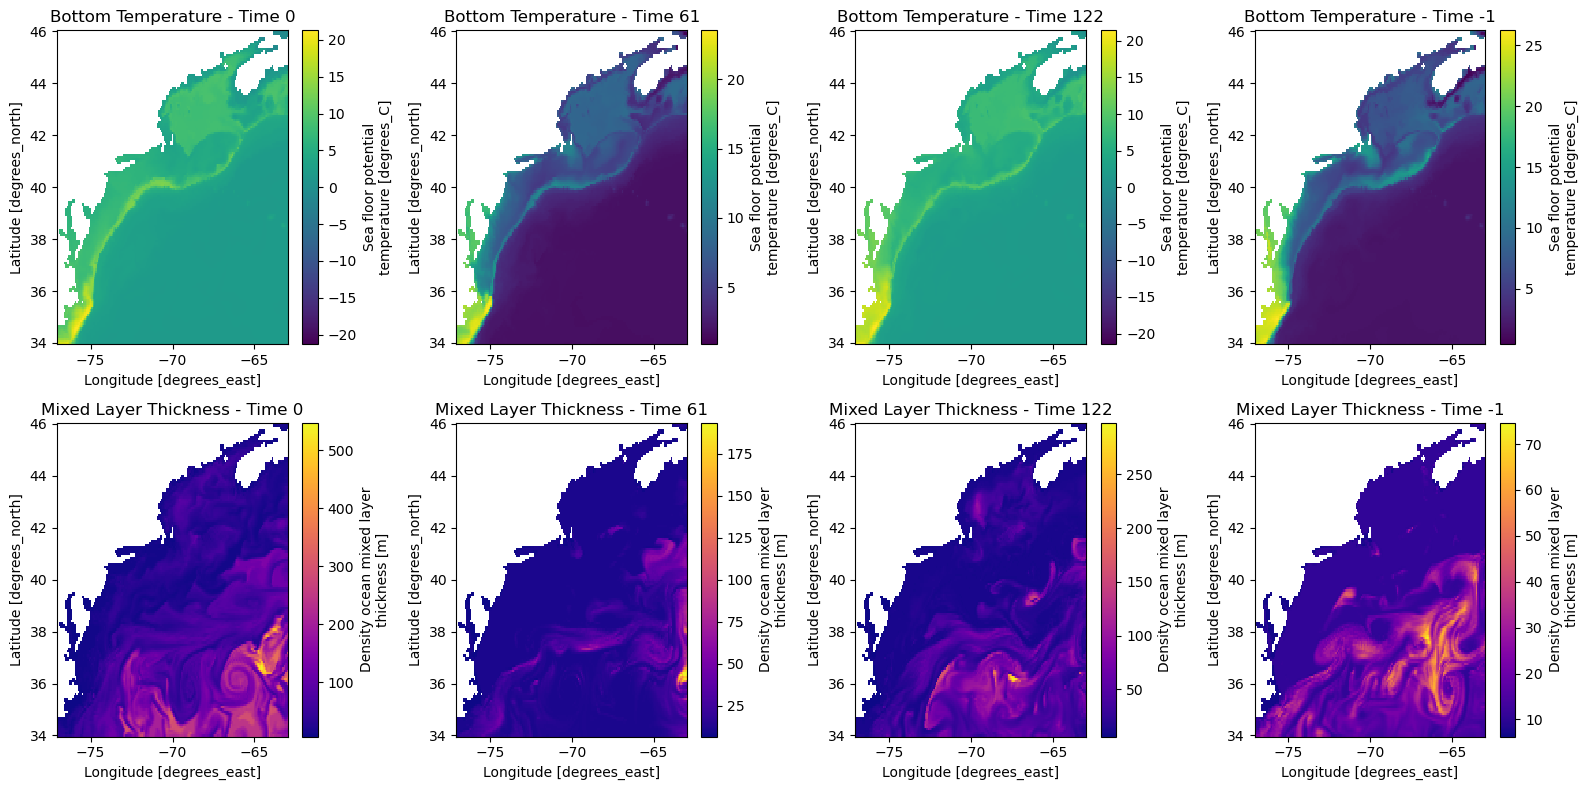

In [12]:
# Select four time slices (modify indices if needed)
time_indices = [0, int(len(glorys_subset.time)/3), int(2*len(glorys_subset.time)/3), -1]

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

for i, t in enumerate(time_indices):
    # Plot 
    ax = axes[0, i]
    glorys_subset.bottomT.isel(time=t).plot(ax=ax, cmap="viridis")
    ax.set_title(f"Bottom Temperature - Time {t}")

    # Plot 2
    ax = axes[1, i]
    glorys_subset.mlotst.isel(time=t).plot(ax=ax, cmap="plasma")
    ax.set_title(f"Mixed Layer Thickness - Time {t}")

# Adjust layout
plt.tight_layout()
plt.show()


Now its **match-up** time again! 

In [6]:
# --- Vectorized Extraction ---

# 1. Create DataArrays for coordinates from your standardized catch_df.
#    The names 'time', 'latitude', 'longitude' now match the env_ds dimensions.
times = xr.DataArray(trawl_df.time.values, dims="observation")
lats = xr.DataArray(trawl_df.latitude.values, dims="observation")
lons = xr.DataArray(trawl_df.longitude.values, dims="observation")

# 2. Extract the 3D variables (bottomT, mlotst) in one go.
#    These variables don't have a 'depth' dimension.
extracted_3d_data = glorys_subset[['bottomT', 'mlotst']].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
)

# 3. Handle the 4D variable (so) separately to deal with depth.
#    Since it's bottom trawl data, we select the deepest available grid cell.
#    .isel(depth=-1) selects the last element along the depth dimension.
extracted_so = glorys_subset['so'].sel(
    time=times,
    latitude=lats,
    longitude=lons,
    method="nearest"
).isel(depth=-1) # Select the bottom-most depth layer

# --- Merge results back into your original DataFrame ---

# Add the extracted 3D variables
trawl_df['bottom_temp'] = extracted_3d_data['bottomT'].values
trawl_df['mld'] = extracted_3d_data['mlotst'].values

# Add the extracted bottom salinity
trawl_df['bottom_salinity'] = extracted_so.values

# --- Display the final merged DataFrame ---
print("\n--- FINAL MERGED DATA ---")
# Displaying relevant columns for verification
final_columns = [
    'time', 'latitude', 'longitude', 'MEAN_DEPTH',
    'bottom_temp', 'mld', 'bottom_salinity'
]
print(trawl_df[final_columns].head())

# Check for any missing values, which could indicate a mismatch
print("\nMissing values count:")
print(trawl_df[final_columns].isnull().sum())


--- FINAL MERGED DATA ---
                 time   latitude  longitude  MEAN_DEPTH  bottom_temp  \
0 2024-03-07 10:58:00  38.659194 -74.828083          24     6.877743   
1 2024-03-07 14:32:00  38.498596 -74.477395          40     7.566973   
2 2024-03-07 17:44:00  38.411974 -74.502885          39     7.698813   
3 2024-03-07 20:29:00  38.505238 -74.832046          25     6.991272   
4 2024-03-07 22:45:00  38.556784 -74.897495          21     6.862362   

         mld  bottom_salinity  
0  10.528886              NaN  
1  10.834071              NaN  
2  10.528886              NaN  
3  10.528886              NaN  
4  10.528886              NaN  

Missing values count:
time                 0
latitude             0
longitude            0
MEAN_DEPTH           0
bottom_temp          1
mld                  1
bottom_salinity    368
dtype: int64


Annddd now we'll look at our extracted data from the of ALL of our variables! 

Text(0.5, 0.98, 'Matched variables')

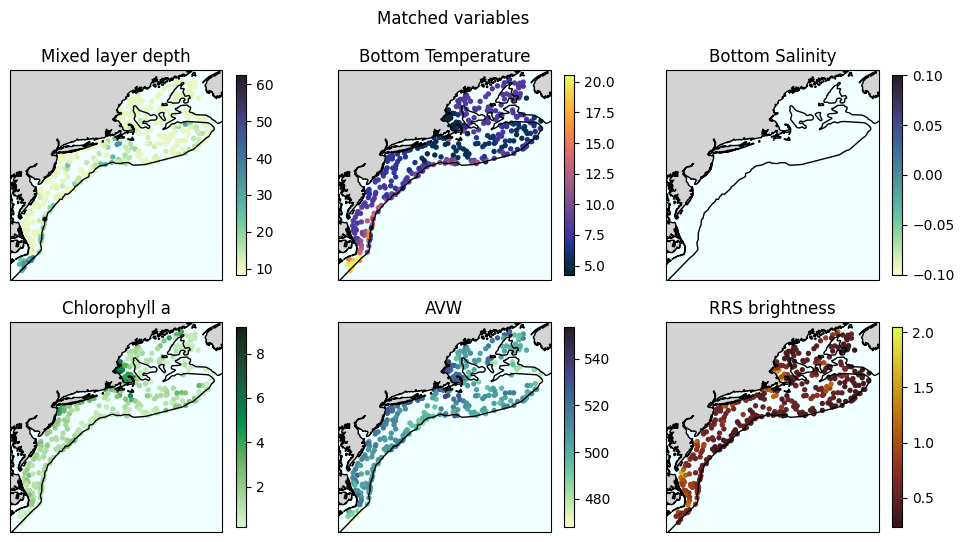

In [15]:
bathym = cfeature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical')
bathym = unary_union(list(bathym.geometries()))
fig, axs = plt.subplots(2, 3, figsize=(12, 6),subplot_kw={'projection': cartopy.crs.PlateCarree()}) 

# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten() 

var=['mld','bottom_temp','bottom_salinity','chlor_a','avw','Rrs_brightness']
var_n = ['Mixed layer depth','Bottom Temperature','Bottom Salinity','Chlorophyll a','AVW','RRS brightness']
# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    if var[i] == 'bottom_temp':
        cmap = cmocean.cm.thermal
    elif var[i] =='chlor_a':
        cmap=cmocean.cm.algae
    elif var[i] == 'Rrs_brightness':
        cmap=cmocean.cm.solar
    else: 
        cmap = cmocean.cm.deep
    im=ax.scatter(trawl_df.longitude, trawl_df.latitude, c=trawl_df[var[i]], label=var[i],s=8, cmap=cmap,vmin=trawl_df[var[i]].min(),vmax=trawl_df[var[i]].max(), )
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=1) #add coastlines
    ax.add_feature(cartopy.feature.LAND,  facecolor='lightgrey') #add land mask 
    ax.add_geometries(bathym, facecolor='none', edgecolor='black', crs=cartopy.crs.PlateCarree()) #add bathymetry line
    ax.add_feature(cfeature.OCEAN, facecolor='azure')
    fig.colorbar(im, ax=ax,shrink=0.95)
    ax.set_title(var_n[i])
fig.suptitle('Matched variables')

And finally some more data cleaning.... We put the chlorophyll data on a log scale and calculated CPUE for each of the species we are using. 

In [7]:
trawl_df['chlor_a'] = [extract_scalar(d) for d in trawl_df.chlor_a] #change dtype from object to scalar
trawl_df['avw'] = [extract_scalar(d) for d in trawl_df.avw] #change dtype from object to scalar


trawl_df['butterfish']= trawl_df['butterfish']/trawl_df['SWEPT_AREA_km']
trawl_df['longfin squid']= trawl_df['longfin squid']/trawl_df['SWEPT_AREA_km']
trawl_df['silver hake']=  trawl_df['silver hake']/trawl_df['SWEPT_AREA_km']
trawl_df['spot']= trawl_df['spot']/trawl_df['SWEPT_AREA_km']


trawl_df['chlora_log10']=[np.log10(d) for d in trawl_df.chlor_a]

## 4. Create SDM model! 
Finally - the part we all came for! <br> 
Time to model the SDM using a boosted regression tree in ```xgboost```. A BTR is a machine learning method that leverages multiple regression trees to create a predictive model. It works by sequentially building trees, where each tree learns from the errors of the trees before it. This iterative process, or "boosting", helps the model to improve its predictions and capture relationships in the data. 

In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
import shap

In [9]:
# --- Step 1: import and back up data ---
df = trawl_df[~trawl_df.avw.isna()] #remove na
#print(df)

In [10]:
# --- Define your target (y) and predictor (X) variables ---
TARGET_SPECIES = ['butterfish', 'silver hake', 'longfin squid', 'spot']

# Exclude species, location, and metadata columns.
PREDICTOR_COLUMNS = ['avw', 'chlor_a', 'MEAN_DEPTH', 'bottom_temp', 'mld', 'Rrs_brightness']
y = np.log1p(df[TARGET_SPECIES])
X_df = df[PREDICTOR_COLUMNS]

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [12]:
# --- Step 2: Model Initialization ---
print("\n--- Step 2: Initializing the XGBoost Model ---")

# Let's define the core parameters.
xgb_reg = xgb.XGBRegressor(
    # --- Boosting Parameters (How the model learns) ---
    n_estimators=1000,         # Analogous to the "richness" of the model. Number of trees to build.
                               # We set this high and use early stopping to find the optimal number.
    learning_rate=0.05,        # Analogous to a shrinkage parameter. Lower values make the model more robust.

    # --- Tree Complexity Parameters ---
    max_depth=5,               # Analogous to `k` in s(x, k=...). Controls max interaction depth.
    min_child_weight=1,        # A form of regularization. Prevents learning highly specific patterns.
    gamma=0.1,                 # Analogous to `sp`. A value > 0 penalizes splits, making the model more conservative.
    subsample=0.8,             # Use 80% of data for building each tree. Adds randomness to fight overfitting.
    colsample_bytree=0.8,      # Use 80% of features for building each tree. Also for overfitting.

    # --- Regularization Parameters ---
    reg_alpha=0.005,           # L1 regularization on leaf weights.
    reg_lambda=1,              # L2 regularization on leaf weights.

    # --- Technical Parameters ---
    objective='reg:squarederror', # The loss function to optimize.
    n_jobs=-1,                 # Use all available CPU cores.
    random_state=42,           # For reproducibility.
    eval_metric='rmse'         # Metric to monitor during training.
)

print("Model initialized with parameters:")
print(xgb_reg.get_params())


--- Step 2: Initializing the XGBoost Model ---
Model initialized with parameters:
{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 1000, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.005, 'reg_lambda': 1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [13]:
# --- Step 3 Model Training ---
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False) # Set verbose=True to see the training progress

print(f"Model training complete.")

Model training complete.


In [14]:
results = xgb_reg.evals_result()
best_iteration = np.argmin(results['validation_0']['rmse'])
best_score = results['validation_0']['rmse'][best_iteration]

print(f"Best iteration found: {best_iteration}")
print(f"Best validation RMSE: {best_score:.4f}")

Best iteration found: 662
Best validation RMSE: 2.4687


In [15]:
# --- Step 4: Making Predictions ---
print("\n--- Step 4: Making Predictions ---")
predictions = xgb_reg.predict(X_val)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, predictions))
print(f"Final RMSE on validation data: {rmse:.4f}")


--- Step 4: Making Predictions ---
Final RMSE on validation data: 2.4693


## 5. Visualize results


--- Step 5: Interpreting the Model ---
Plotting feature importance...


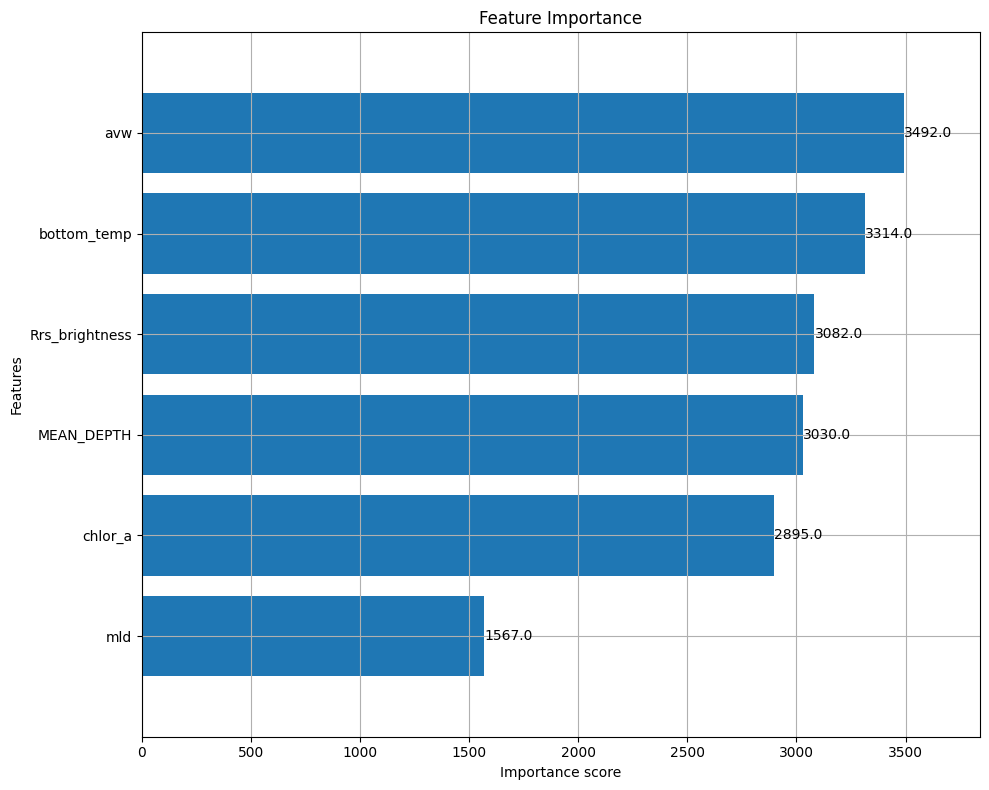

In [16]:
# --- Step 5: Model Interpretation (The `mgcv::plot.gam` Analogy) ---


print("\n--- Step 5: Interpreting the Model ---")

# 5a. Feature Importance
print("Plotting feature importance...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=ax, max_num_features=10, height=0.8, title="Feature Importance")
plt.tight_layout()
plt.show()


Calculating and plotting SHAP values...


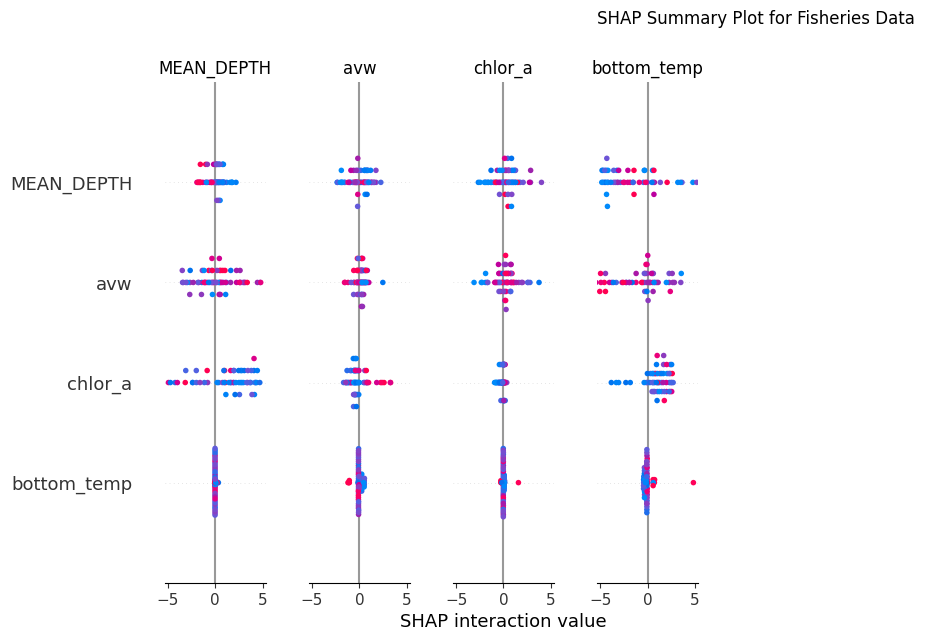

In [17]:
# 5b. SHAP Values 
print("\nCalculating and plotting SHAP values...")
# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_reg)

# Calculate SHAP values for the validation set

shap_values = explainer.shap_values(X_val)

# Summary plot: Shows the distribution of impacts for each feature.
# Red means high feature value, blue means low.
# Points to the right increase the prediction, points to the left decrease it.
shap.summary_plot(shap_values, X_val, plot_type="dot", show=False)
plt.title("SHAP Summary Plot for Fisheries Data",y=1.1,loc='left')
plt.tight_layout()
plt.show()


--- Creating Partial Dependence Plots for ['butterfish', 'silver hake', 'longfin squid', 'spot'] ---


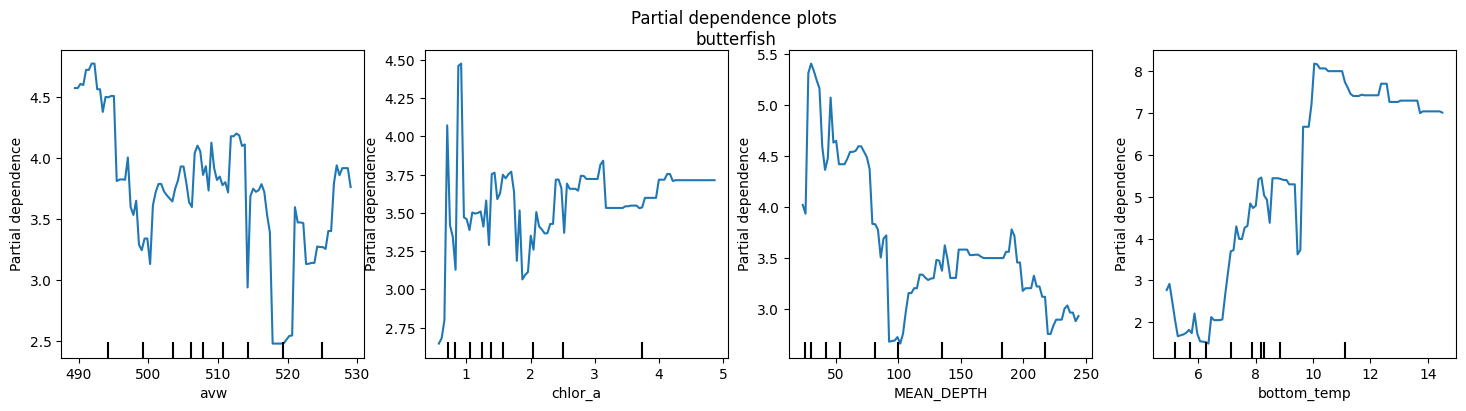

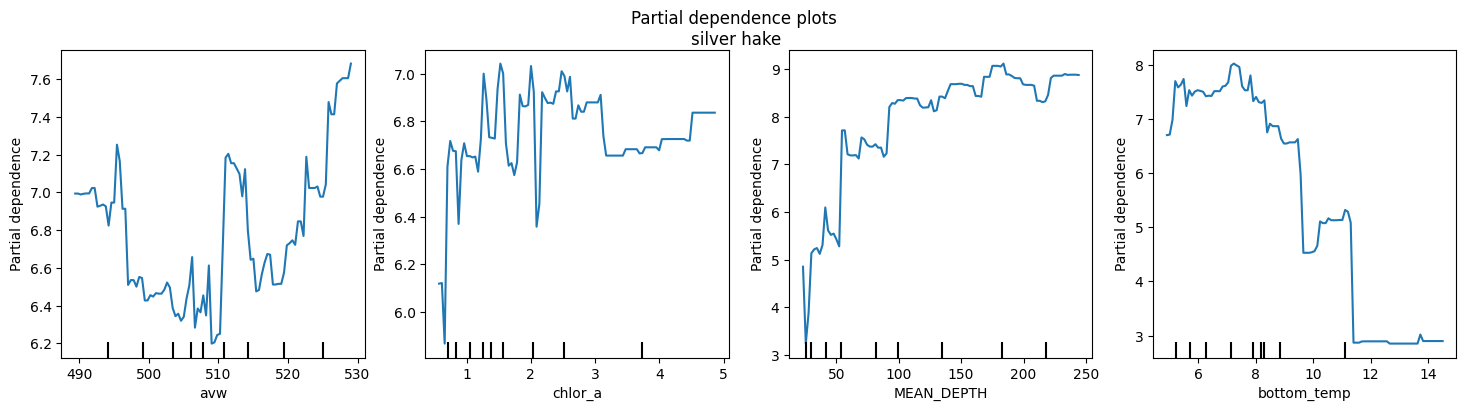

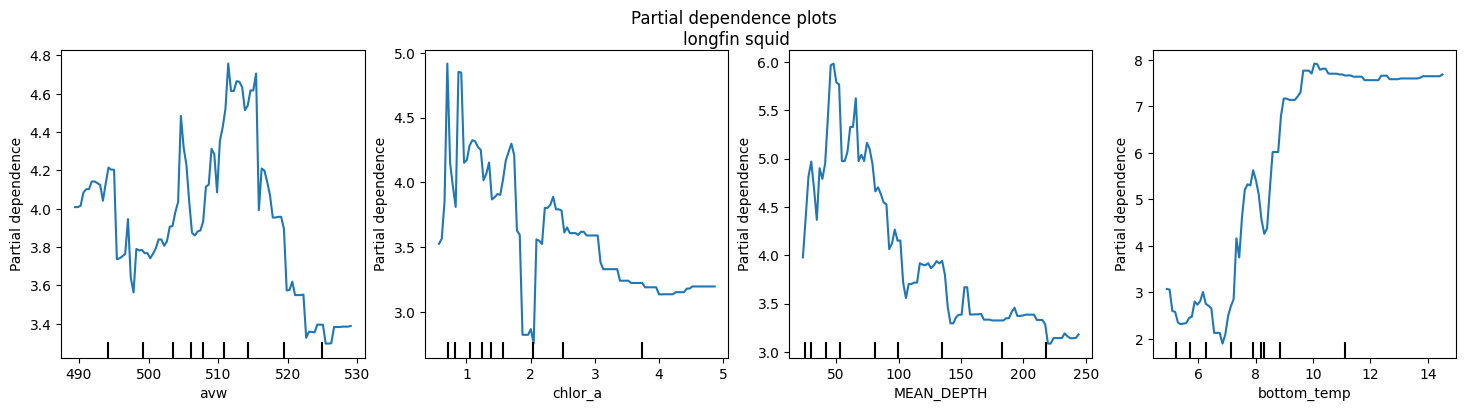

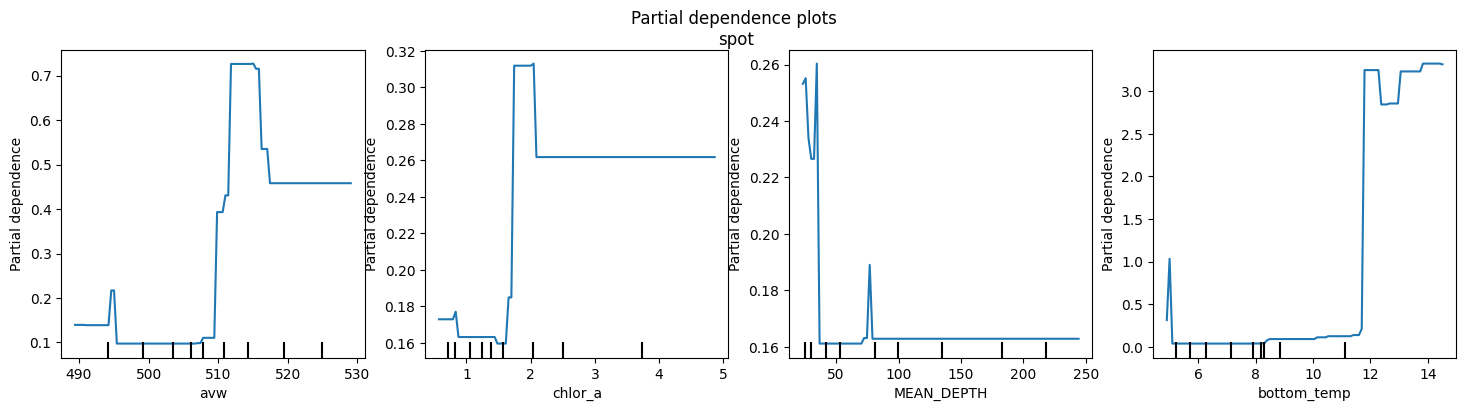

In [18]:
from sklearn.inspection import PartialDependenceDisplay
# --- Step 9: Create Partial Dependence Plots ---
print(f"\n--- Creating Partial Dependence Plots for {TARGET_SPECIES} ---")

# The PDP shows the marginal effect one or two features have on the predicted outcome.
for s, species in enumerate(TARGET_SPECIES):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
    # Flatten the axs array for easy iteration if needed, though direct indexing works too
    axs = axs.flatten()
    
    # Loop through each subplot and plot data
    for i, ax in enumerate(axs):
        PartialDependenceDisplay.from_estimator(
                            estimator=xgb_reg,
                            X=X_train,
                            features=[X_train.columns[i]],
                            target=s,  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    fig.suptitle(f'Partial dependence plots \n{species}')

In [19]:
values = explainer.shap_values(X_val)

print(f"Type of the main SHAP variable: {type(values)}")
print(f"Number of target outputs found: {len(values)}")
print("---")
print(f"Shape of SHAP values for the FIRST target: {values[0].shape}")
print(f"Shape of the X_val DataFrame: {X_val.shape}")

# This check should return True
print(f"\nDo the number of rows match? {values[0].shape[0] == X_val.shape[0]}")

Type of the main SHAP variable: <class 'numpy.ndarray'>
Number of target outputs found: 65
---
Shape of SHAP values for the FIRST target: (6, 4)
Shape of the X_val DataFrame: (65, 6)

Do the number of rows match? False


Confirmed shape of SHAP values array: (65, 6, 4)

--- Generating SHAP Dependence Plot for: butterfish ---
Shape of sliced SHAP values for butterfish: (65, 6)


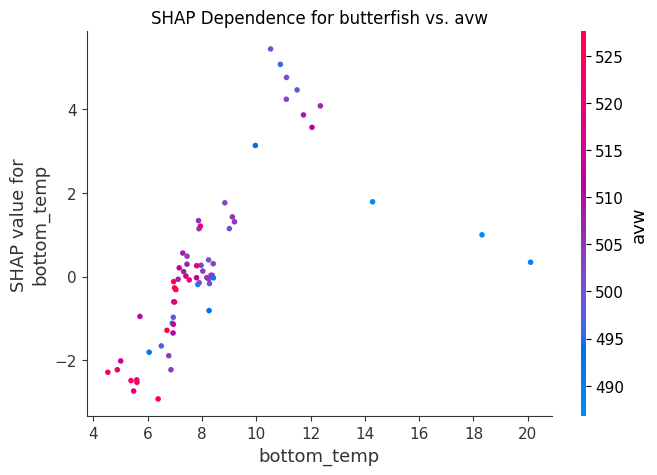


--- Generating SHAP Dependence Plot for: silver hake ---
Shape of sliced SHAP values for silver hake: (65, 6)


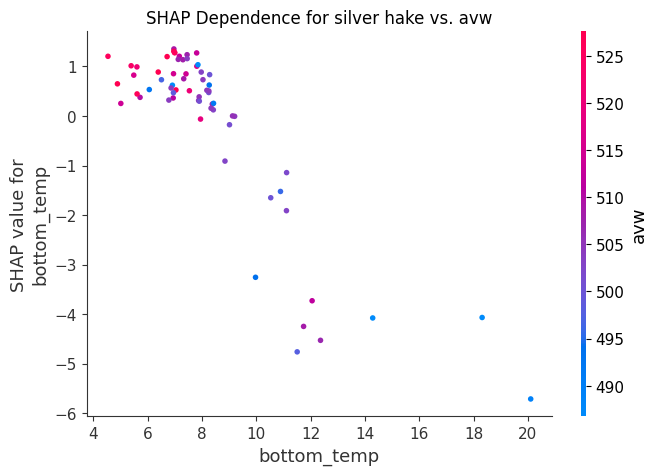


--- Generating SHAP Dependence Plot for: longfin squid ---
Shape of sliced SHAP values for longfin squid: (65, 6)


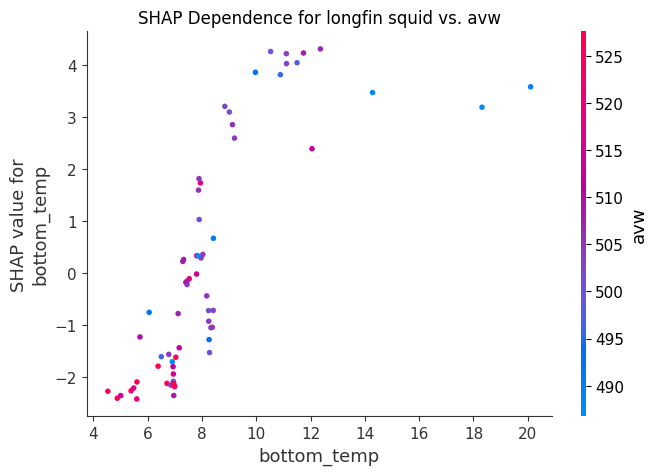


--- Generating SHAP Dependence Plot for: spot ---
Shape of sliced SHAP values for spot: (65, 6)


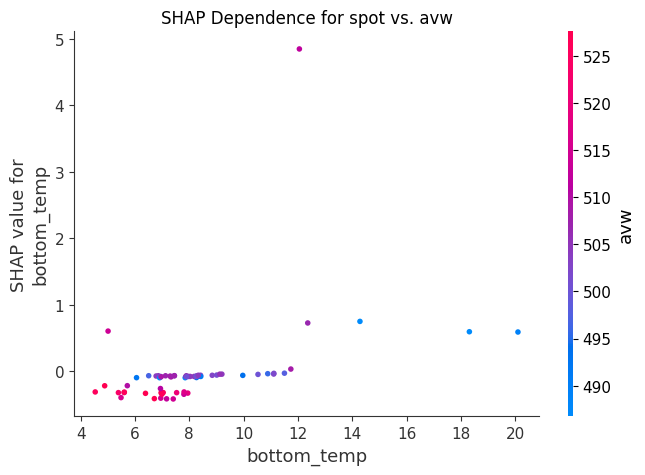

In [20]:
import shap
import matplotlib.pyplot as plt

# Calculate the SHAP values
values = explainer.shap_values(X_val)

# Let's verify the shape of the 3D array
print(f"Confirmed shape of SHAP values array: {values.shape}") # Should be (74, 6, 4)

# Loop through each target species by its index (0, 1, 2, 3)
for i, species in enumerate(TARGET_SPECIES):
    print(f"\n--- Generating SHAP Dependence Plot for: {species} ---")

    # Select the slice for the current species.
    shap_values_for_species = values[:, :, i]

    # Now, shap_values_for_species has the correct 2D shape: (74, 6)
    print(f"Shape of sliced SHAP values for {species}: {shap_values_for_species.shape}")

    # Create the dependence plot with the correctly shaped array
    shap.dependence_plot(
        "bottom_temp",                 # Feature for the x-axis
        shap_values_for_species,       # The correctly sliced 2D array
        X_val,                         # The feature data
        interaction_index="avw",       # Optional: feature to color by
        show=False
    )
    plt.title(f"SHAP Dependence for {species} vs. avw")
    plt.show()

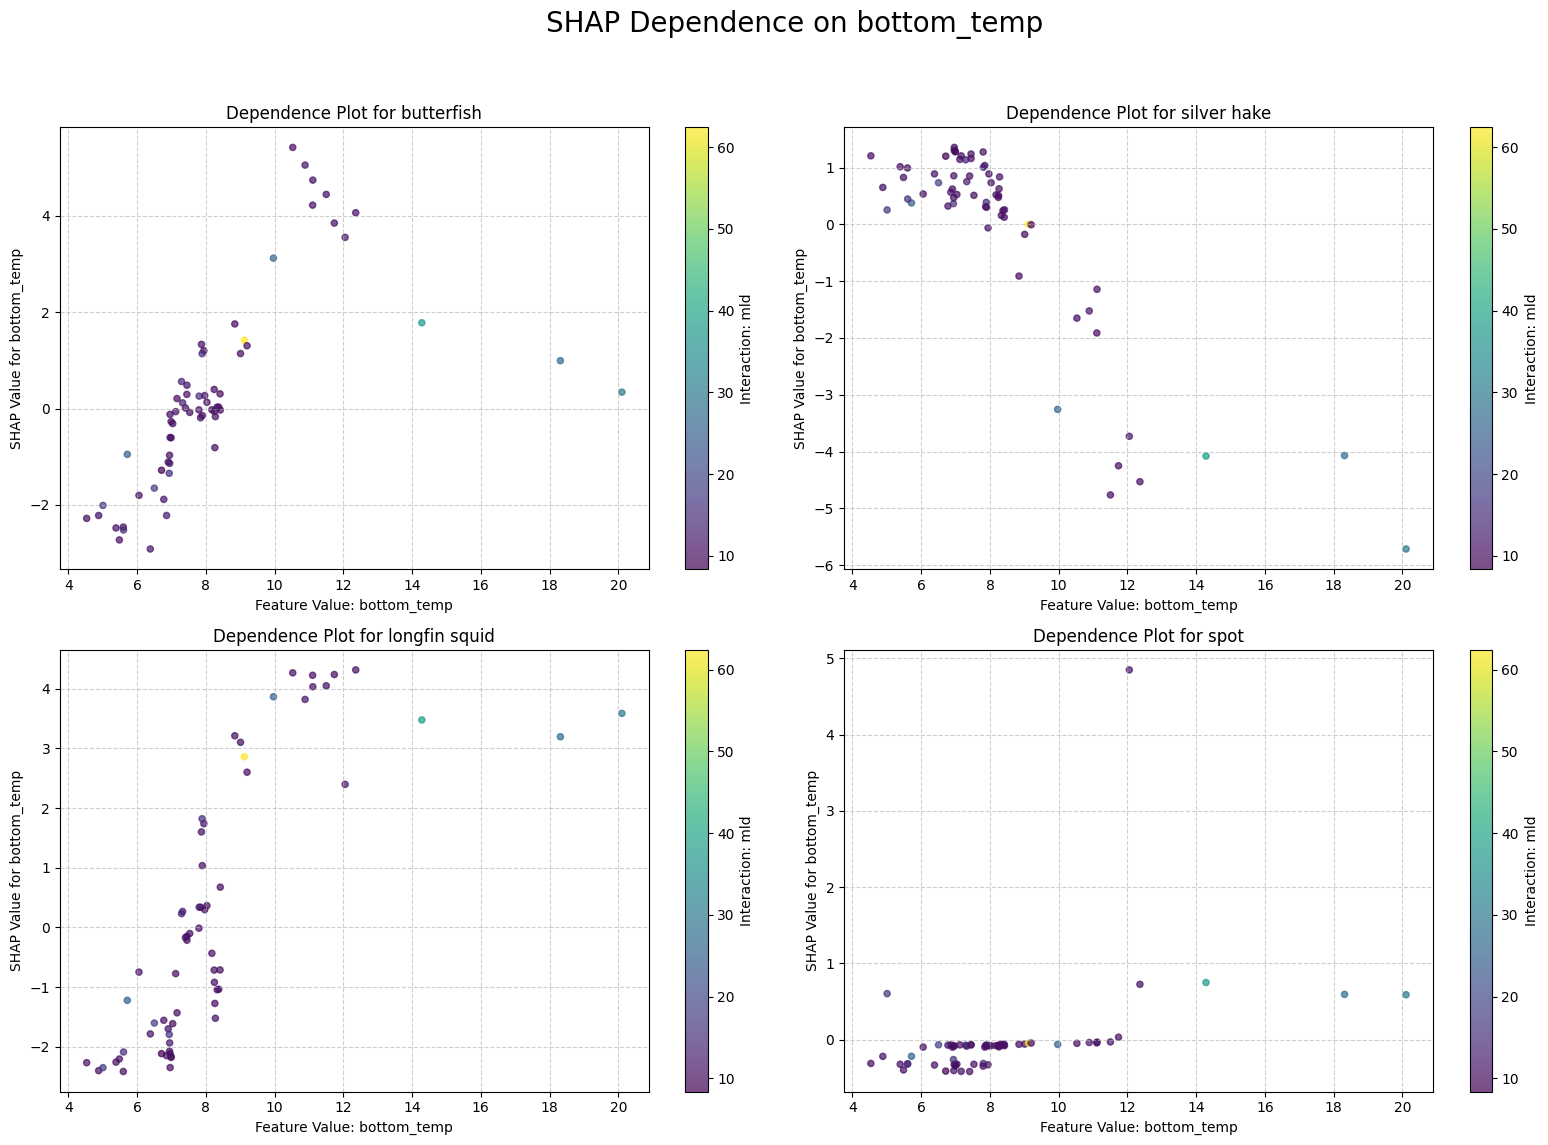

In [21]:
values = explainer.shap_values(X_val)

# --- SHAP Dependence Grid ---

# 1. Define the features you want to plot
feature_to_plot = "bottom_temp"
interaction_feature = "mld"

# 2. Create the 2x2 grid
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
axs = axs.flatten()

# 3. Get the integer column index for your features. 
try:
    feature_idx = X_val.columns.get_loc(feature_to_plot)
except KeyError:
    print(f"Error: Feature '{feature_to_plot}' not in X_val columns!")
    # Handle error appropriately
    feature_idx = None

# 4. Loop through each species and draw the plot on the correct subplot
if feature_idx is not None:
    for i, species in enumerate(TARGET_SPECIES):
        ax = axs[i]

        # Slice the 3D SHAP array to get values for the current species
        shap_values_for_species = values[:, :, i]

        # Create the scatter plot directly on the subplot 'ax'
        scatter = ax.scatter(
            x=X_val.iloc[:, feature_idx],  # Use the index to get feature values
            y=shap_values_for_species[:, feature_idx], # Get SHAP values for that feature
            c=X_val[interaction_feature], # Use the interaction feature for color
            cmap='viridis',
            alpha=0.7,
            s=20 # Adjust point size if needed
        )

        # Add a colorbar for the interaction feature
        cbar = fig.colorbar(scatter, ax=ax)
        cbar.set_label(f"Interaction: {interaction_feature}")

        # Set titles and labels for the subplot
        ax.set_title(f"Dependence Plot for {species}")
        ax.set_xlabel(f"Feature Value: {feature_to_plot}")
        ax.set_ylabel(f"SHAP Value for {feature_to_plot}")
        ax.grid(True, linestyle='--', alpha=0.6)

# 5. Add a main title and display the single, completed figure
fig.suptitle(f"SHAP Dependence on {feature_to_plot}", fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

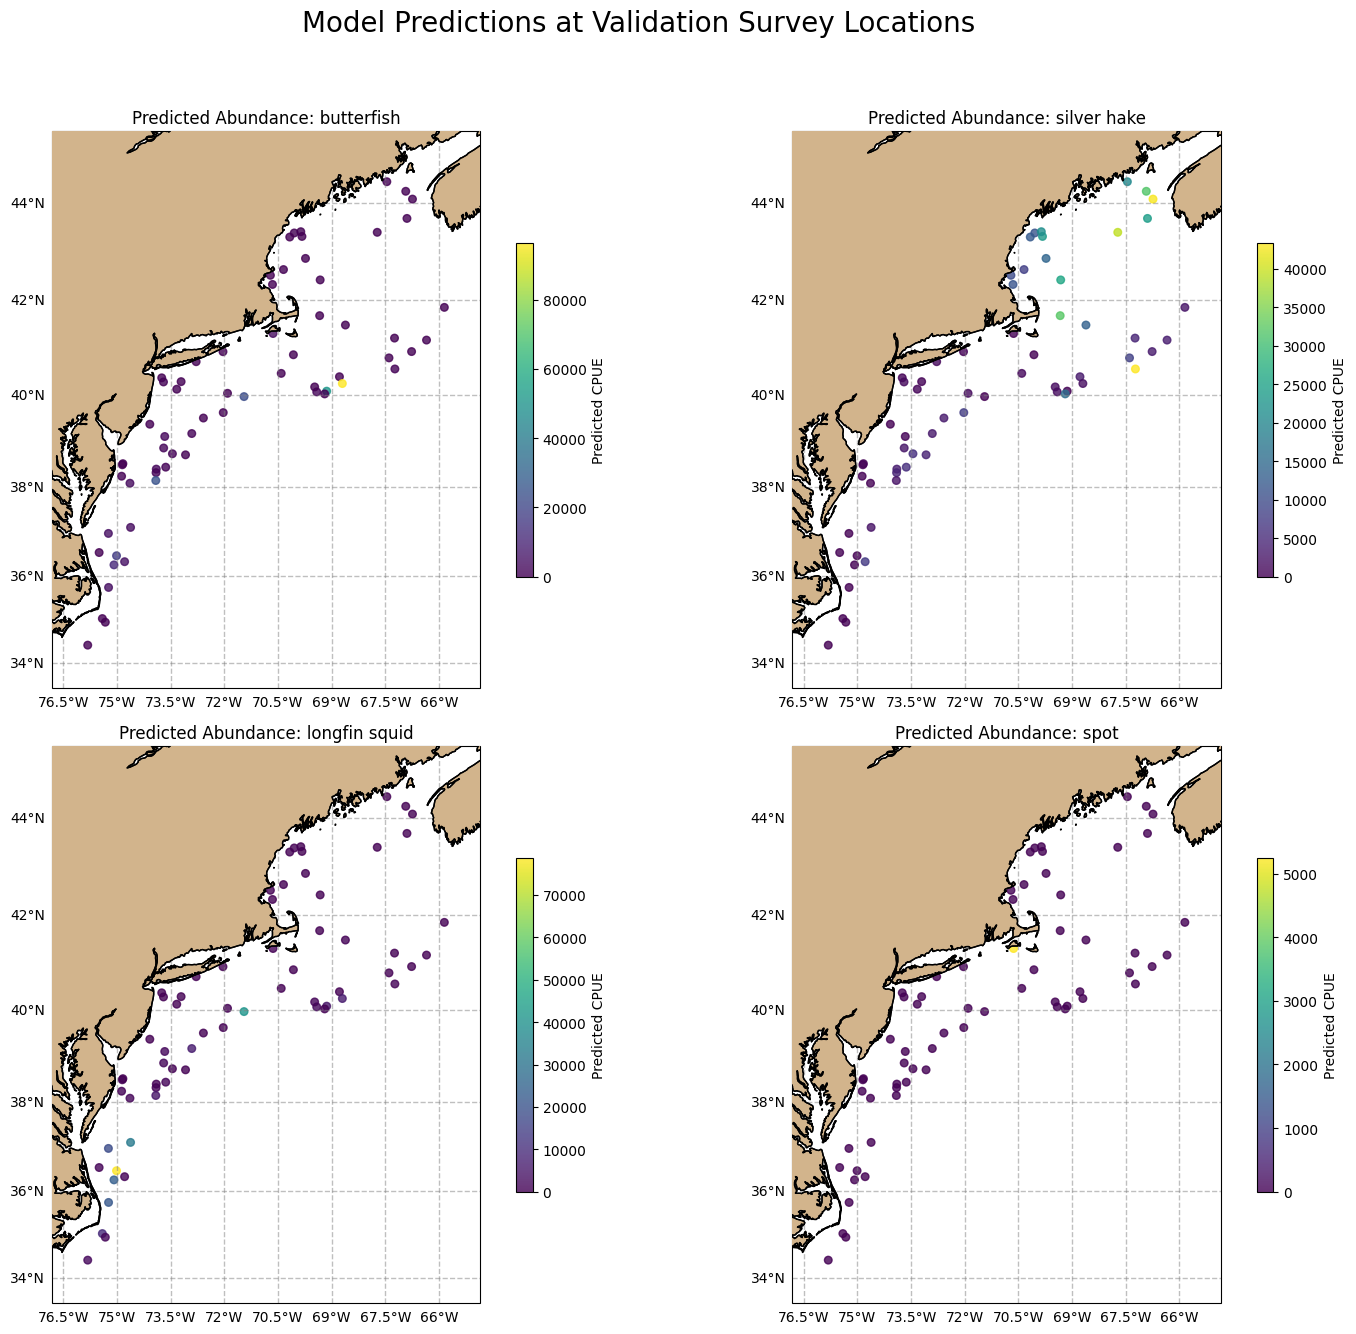

In [23]:
import cartopy.crs as ccrs
# 1. Get the model predictions for the validation set
# This gives you the predicted log-CPUE for each point in X_val
predictions_log = xgb_reg.predict(X_val)
# Convert back from log scale to the original CPUE scale
predictions_cpue = np.expm1(predictions_log)

# 2. Get the latitude and longitude for the validation points
val_coords = df.loc[X_val.index]

# 3. Create a 2x2 grid of maps
fig, axs = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(15, 14),
    subplot_kw={'projection': ccrs.Mercator()}
)
axs = axs.flatten()

for i, species in enumerate(TARGET_SPECIES):
    ax = axs[i] # Select the subplot for the current species

    # Set the geographic extent of the map based on your data
    ax.set_extent([
        val_coords['longitude'].min() - 1, val_coords['longitude'].max() + 1,
        val_coords['latitude'].min() - 1, val_coords['latitude'].max() + 1
    ], crs=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND, zorder=5, edgecolor='black', facecolor='tan')
    ax.add_feature(cfeature.COASTLINE, zorder=5)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Draw gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # Create the scatter plot
    # x and y are the coordinates
    # c is the color, based on the prediction for the current species
    scatter = ax.scatter(
        x=val_coords['longitude'],
        y=val_coords['latitude'],
        c=predictions_cpue[:, i], # Select the prediction column for this species
        cmap='viridis',
        transform=ccrs.PlateCarree(),
        s=30, # Adjust point size
        alpha=0.8
    )

    # Add a colorbar for each subplot
    cbar = fig.colorbar(scatter, ax=ax, shrink=0.6, orientation='vertical')
    cbar.set_label('Predicted CPUE')

    # Set the title for the subplot
    ax.set_title(f'Predicted Abundance: {species}')

# Add a main title for the entire figure
fig.suptitle('Model Predictions at Validation Survey Locations', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Predicting on new data 
Ooppp, we didn't get there yet! 
We would've liked to use our model to predict values for 2025 (and ideally compare with the 2025 bottom trawl survey data), but we ran out of time. 

## Future Work
* Predict on new, independent data
* Clean up/ add more markdown comments to turn this into a tutorial
  * Host final version on Github
* Continue to interpret results
  * Hyperparameterize model
  * Use different package to forward or backward predict abundance 
* Create requirements file so it can be run in a containerized environment
* Combine with other trawl surveys (at least BTS 2025), so we would like to re-run the model with more available PACE data
  * Pair with environmental data from survey 

Thank you to the organizers and mentors of this amazing hackweek!!!! Thank you to Eli Holmes for the project-specific mentorship and Ryan Vandermeulen for his code generosity and project-specific mentorship! 